# Final Decision Tree

## Importing Libraries and the Dataset 

In [3]:
pip install PyALE

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.inspection import plot_partial_dependence
from PyALE import ale

In [2]:
df = pd.read_csv("Cleaned and Prepared Dataset (RF Input).csv")

In [3]:
print(df.shape)
df.head()

(19825, 33)


,HOUSEID,TDTRPNUM,VEHID,PERSONID,HOMEOWN,HHSIZE,HHFAMINC,DRVRCNT,WRKCOUNT,YOUNGCHILD,...,STRTTIME_CAT,TRIPPURP_CAT,WHYTO_CAT,DWELTIME_CAT,TRPMILES_CAT,NUMONTRP_CAT,CLUSTER,GASPRICE,GASPRICE_USD,FUELTYPE_BIN
0,30000775,1,2,2,1,2,2,2,0,0,...,10 AM - 3 PM,Home based trip,Social & recreational,50-150 minutes,2-5 miles,1 passenger,1,220.3,2.203,1
1,30000775,3,1,1,1,2,2,2,0,0,...,3 PM - 7 PM,Home based trip,Errands,1-15 minutes,0-2 miles,1 passenger,3,220.3,2.203,3
2,30000775,3,2,2,1,2,2,2,0,0,...,10 AM - 3 PM,non-home based trip,Shopping & Dining,1-15 minutes,0-2 miles,1 passenger,1,220.3,2.203,1
3,30000775,2,2,2,1,2,2,2,0,0,...,10 AM - 3 PM,non-home based trip,Shopping & Dining,15-50 minutes,2-5 miles,1 passenger,1,220.3,2.203,1
4,30000775,1,1,1,1,2,2,2,0,0,...,6 AM - 10 AM,Home based trip,Social & recreational,50-150 minutes,2-5 miles,1 passenger,2,220.3,2.203,3


In [4]:
df.columns

Index(['HOUSEID', 'TDTRPNUM', 'VEHID', 'PERSONID', 'HOMEOWN', 'HHSIZE',
       'HHFAMINC', 'DRVRCNT', 'WRKCOUNT', 'YOUNGCHILD', 'LIF_CYC_CAT', 'R_AGE',
       'EDUC', 'R_SEX', 'WORKER', 'HTPPOPDN', 'HTEEMPDN', 'HBPPOPDN',
       'OTEEMPDN', 'OBPPOPDN', 'DTEEMPDN', 'DBPPOPDN', 'TDWKND',
       'STRTTIME_CAT', 'TRIPPURP_CAT', 'WHYTO_CAT', 'DWELTIME_CAT',
       'TRPMILES_CAT', 'NUMONTRP_CAT', 'CLUSTER', 'GASPRICE', 'GASPRICE_USD',
       'FUELTYPE_BIN'],
      dtype='object')

## Data Preprocessing 

In [5]:
df = df [["HOMEOWN", 'HHFAMINC', "WRKCOUNT", "YOUNGCHILD", "R_AGE", "EDUC", "R_SEX", "HTPPOPDN", "HTEEMPDN", "CLUSTER", "GASPRICE", "FUELTYPE_BIN"]]

In [6]:
df["HOMEOWN"].replace(2,0, inplace=True)
df["HTPPOPDN"] = df["HTPPOPDN"].round(2)
df["HTEEMPDN"] = df["HTEEMPDN"].round(2)
df["R_SEX"].replace(2,0, inplace=True)
df["FUELTYPE_BIN"].replace(3,0, inplace=True)
df = df[df["FUELTYPE_BIN"].isin([0,1])] #Dropping other AFV types
df.reset_index(drop=True, inplace=True)

In [7]:
df_unencoded = df [["HOMEOWN",'HHFAMINC', "WRKCOUNT", "YOUNGCHILD", "R_AGE", "EDUC", "R_SEX", "HTPPOPDN", "HTEEMPDN", "CLUSTER", "GASPRICE"]]

In [8]:
one_hot_encoder = OneHotEncoder().fit(df[["CLUSTER"]])
def onehot_encode(feat, ohe=one_hot_encoder):
    col_names = [str(feat.columns[0])+str(cat) for cat in ohe.categories_[0]]
    feat_coded = pd.DataFrame(ohe.transform(feat).toarray())
    feat_coded.columns = col_names
    return feat_coded

In [9]:
nominals = ["CLUSTER", "FUELTYPE_BIN"]
df_num = df.drop(columns=nominals, axis=1)

df_encoded = pd.concat([df_num, onehot_encode(df[["CLUSTER"]])], axis=1)

print(df_encoded.shape)
df_encoded.head()

(19825, 15)


,HOMEOWN,HHFAMINC,WRKCOUNT,YOUNGCHILD,R_AGE,EDUC,R_SEX,HTPPOPDN,HTEEMPDN,GASPRICE,CLUSTER1,CLUSTER2,CLUSTER3,CLUSTER4,CLUSTER5
0,1,2,0,0,73,3,1,7.0,3.0,220.3,1.0,0.0,0.0,0.0,0.0
1,1,2,0,0,68,3,0,7.0,3.0,220.3,0.0,0.0,1.0,0.0,0.0
2,1,2,0,0,73,3,1,7.0,3.0,220.3,1.0,0.0,0.0,0.0,0.0
3,1,2,0,0,73,3,1,7.0,3.0,220.3,1.0,0.0,0.0,0.0,0.0
4,1,2,0,0,68,3,0,7.0,3.0,220.3,0.0,1.0,0.0,0.0,0.0


## Training and Testing the Decision Tree 

In [59]:
X = df_unencoded
Y = df[["FUELTYPE_BIN"]]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.15, random_state=3)

X = pd.concat([X_train, X_test], axis=0)
Y = pd.concat([Y_train, Y_test], axis=0)

In [60]:
tree = DecisionTreeClassifier(min_samples_split=2)

In [53]:
tree.fit(X_train, Y_train)

DecisionTreeClassifier()

In [13]:
path = tree.cost_complexity_pruning_path(X_train, Y_train)
alphas, impurities = path.ccp_alphas, path.impurities

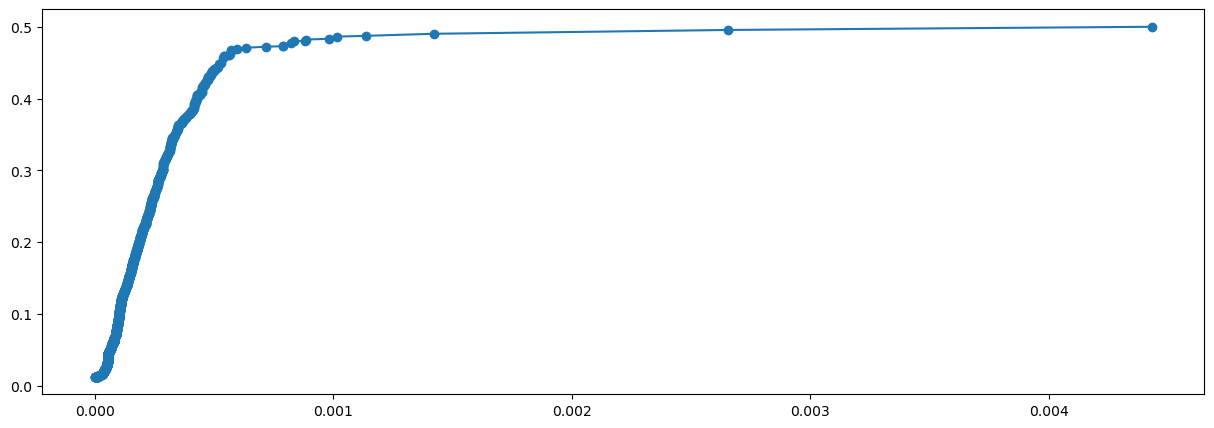

In [15]:
fig, axs = plt.subplots(1,1,figsize=(15,5))
plt.plot(alphas, impurities, marker="o")

In [ ]:
train_accuracies = []
test_accuracies = []

for alpha in alphas:
    tree = DecisionTreeClassifier(min_samples_split=2, ccp_alpha=alpha)
    tree.fit(X_train, Y_train)
    predictions_train = tree.predict(X_train)
    train_accuracies.append(accuracy_score(Y_train, predictions_train))
    predictions_test = tree.predict(X_test)
    test_accuracies.append(accuracy_score(Y_test, predictions_test))

fig, axs = plt.subplots(1,1,figsize=(10,5))
axs = plt.plot(alphas[2:], train_accuracies, color="blue")
axs = plt.plot(alphas[2:], test_accuracies, color="red")

In [61]:
tree = DecisionTreeClassifier(min_samples_split=2, ccp_alpha=0)
tree.fit(X_train, Y_train)

DecisionTreeClassifier(ccp_alpha=0)

In [62]:
predictions_overall = tree.predict(X)
predictions_train = tree.predict(X_train)
predictions_test = tree.predict(X_test)

print(f"Overall Accuracy: {tree.score(X, Y)}")
print(f"Train Accuracy: {tree.score(X_train, Y_train)}")
print(f"Test Accuracy: {tree.score(X_test, Y_test)}")

Overall Accuracy: 0.9729129886506935
Train Accuracy: 0.9895555159931161
Test Accuracy: 0.8786146603900471


In [63]:
scores = cross_val_score(tree, X, Y, scoring="accuracy", cv=10)
mean_accuracy = scores.mean()
print(f"Mean accuracy: {mean_accuracy}")
print(scores)

Mean accuracy: 0.8876170964805284
[0.90065557 0.87493696 0.8809884  0.88199697 0.89056984 0.8864783
 0.90010091 0.88849647 0.88446014 0.88748739]


## Interpretation 

In [65]:
#Regular feature importance
feature_importances = {}
for index, column in enumerate(X.columns):
    feature_importances[tree.feature_importances_[index]] = column
variable_importance = pd.DataFrame(sorted(feature_importances.items(), reverse=True))
variable_importance.columns = ["Importance", "Variable"]
variable_importance = variable_importance[["Variable", "Importance"]]
variable_importance

,Variable,Importance
0,GASPRICE,0.331269
1,R_AGE,0.252189
2,HTEEMPDN,0.087815
3,HTPPOPDN,0.078855
4,CLUSTER,0.072756
5,WRKCOUNT,0.059632
6,HHFAMINC,0.054497
7,HOMEOWN,0.018293
8,EDUC,0.016791
9,R_SEX,0.014900


In [ ]:
#Permutation feature importance
from sklearn.inspection import permutation_importance
r = permutation_importance(tree, X, Y, n_repeats=100, random_state=0)
variable_importances = {}
for index, variable in enumerate(list(X.columns)):
    variable_importances[r['importances_mean'][index]] = variable
variable_importances = pd.DataFrame(sorted(variable_importances.items(), reverse=True))
variable_importances.columns = ["Importance", "Variable"]
variable_importances = variable_importances[["Variable", "Importance"]]
variable_importances

C:\Users\vubanc\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


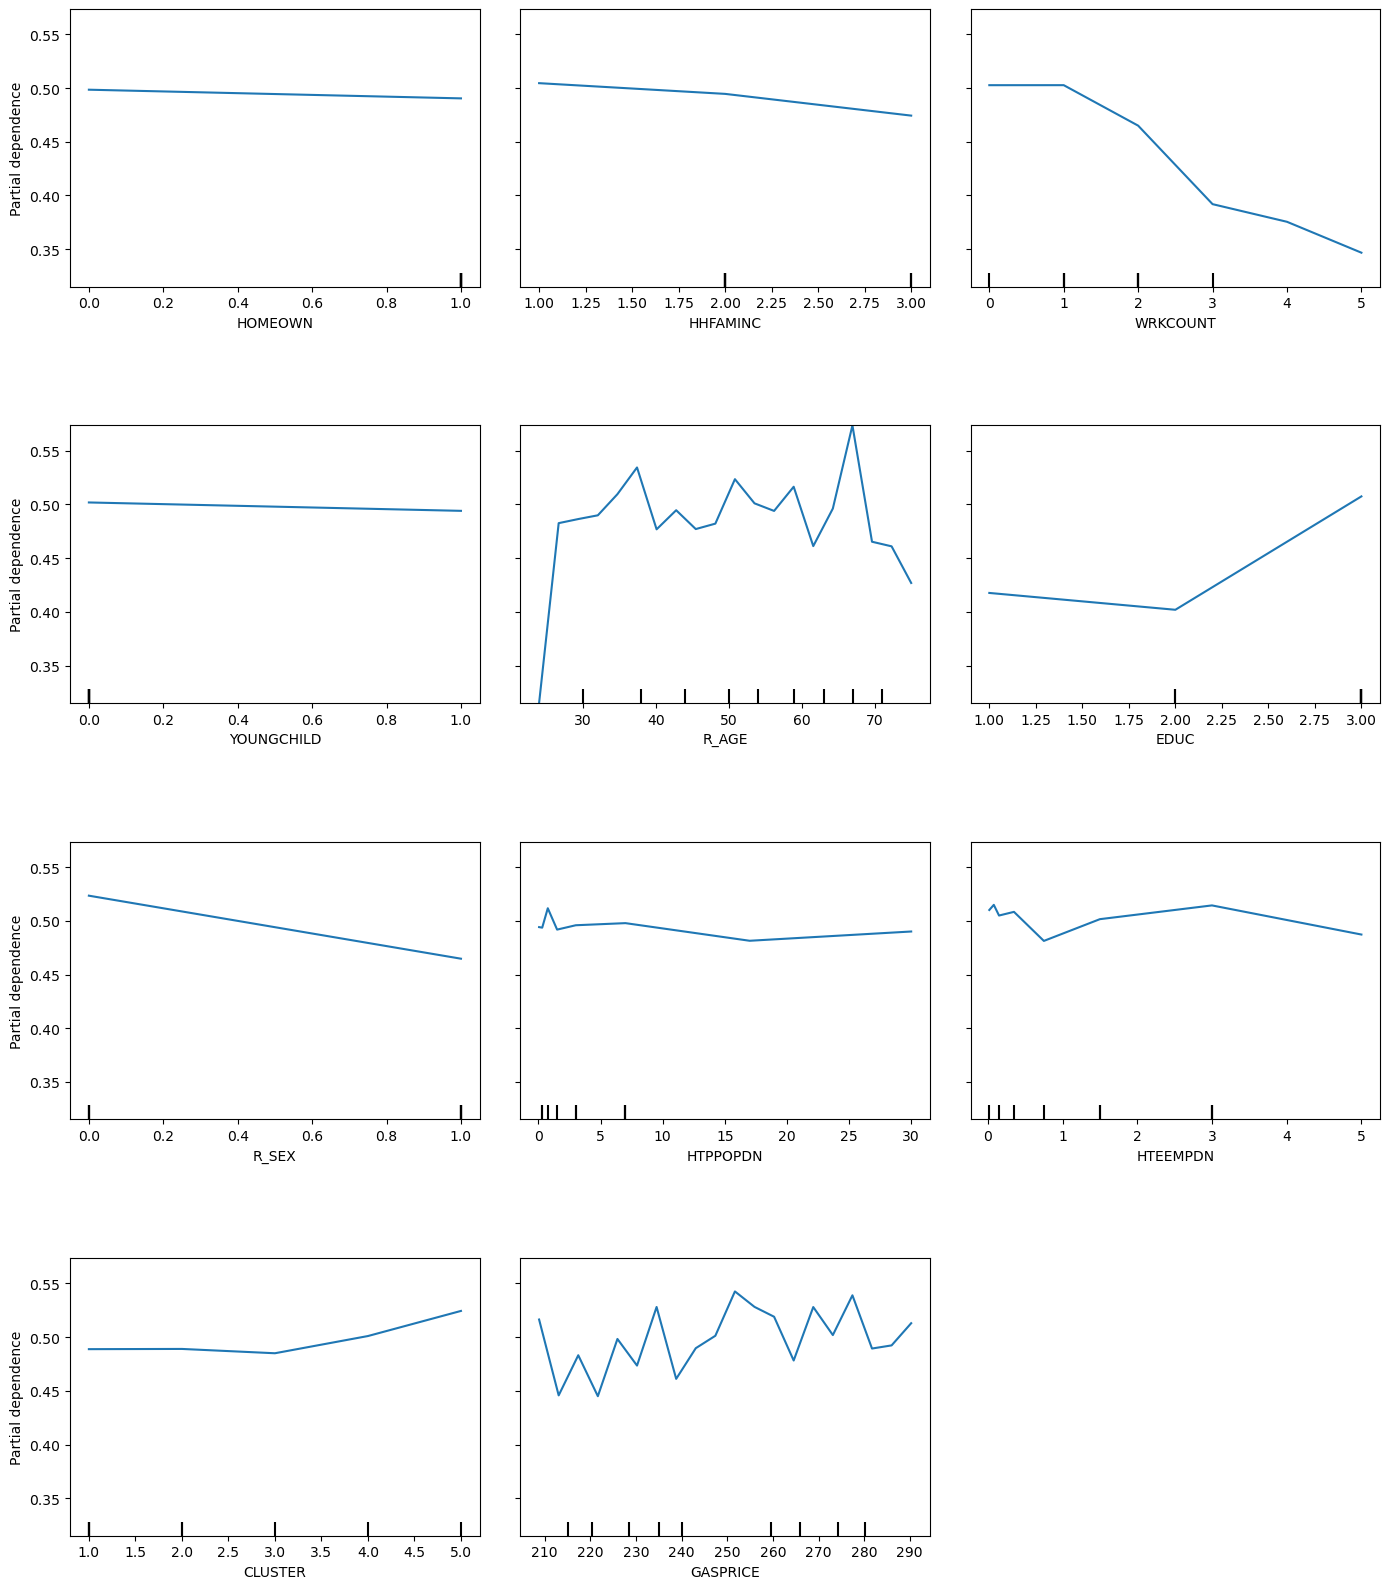

In [31]:
plot_partial_dependence(tree, X, features=list(X.columns), grid_resolution=20)
fig = plt.gcf() #Getcurrent figure
fig.set_size_inches(14,16)
fig.subplots_adjust(wspace=0.1, hspace=0.5)
plt.tight_layout()
plt.show()

fig.savefig("Partial Dependence Plots", bbox_inches="tight")

PyALE._ALE_generic:INFO: Discrete feature detected.
C:\Users\vubanc\Anaconda3\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
C:\Users\vubanc\Anaconda3\lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


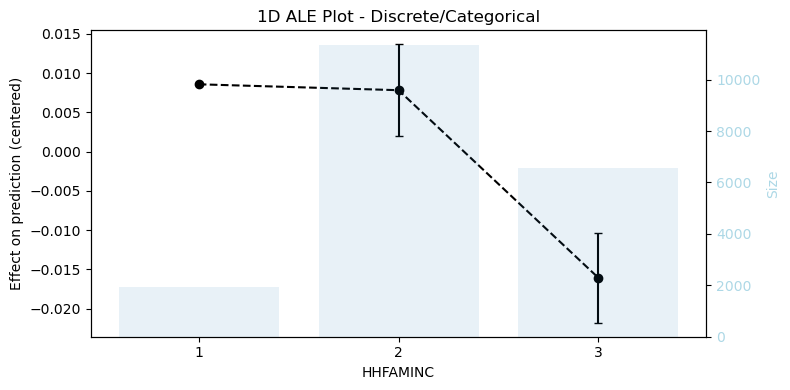

In [66]:
ale(X=df_unencoded, model=tree, feature = ["HHFAMINC"], grid_size=10, include_CI=True, C=0.95)
fig = plt.gcf()
fig.savefig("Effects of Household Income", bbox_inches = "tight")

PyALE._ALE_generic:INFO: Continuous feature detected.


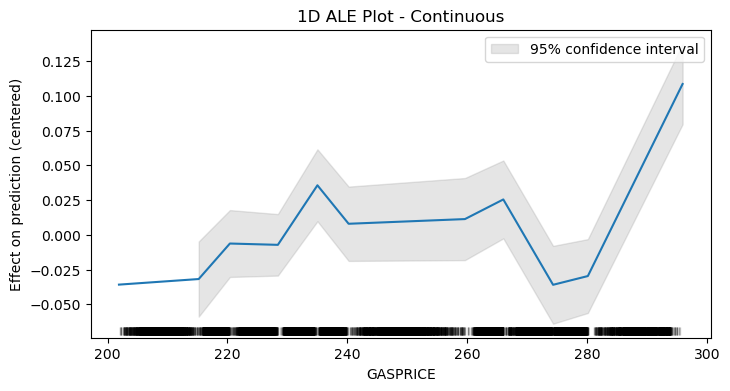

In [67]:
ale(X=df_unencoded, model=tree, feature = ["GASPRICE"], grid_size=10, include_CI=True, C=0.95)
fig = plt.gcf()
fig.savefig("Effects of Gas Price", bbox_inches = "tight")

PyALE._ALE_generic:INFO: Continuous feature detected.


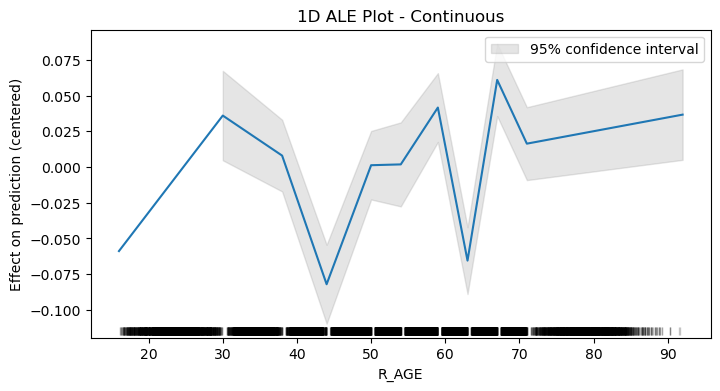

In [68]:
ale(X=df_unencoded, model=tree, feature = ["R_AGE"], grid_size=10, include_CI=True, C=0.95)
fig = plt.gcf()
fig.savefig("Effects of Age", bbox_inches = "tight")

PyALE._ALE_generic:INFO: Discrete feature detected.
C:\Users\vubanc\Anaconda3\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
C:\Users\vubanc\Anaconda3\lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


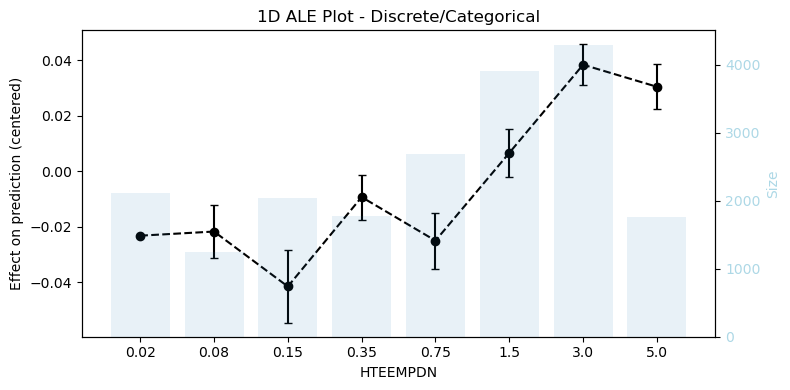

In [69]:
ale(X=df_unencoded, model=tree, feature = ["HTEEMPDN"], grid_size=10, include_CI=True, C=0.95)
fig = plt.gcf()
fig.savefig("Effects of Employment Density", bbox_inches = "tight")

PyALE._ALE_generic:INFO: Discrete feature detected.
C:\Users\vubanc\Anaconda3\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
C:\Users\vubanc\Anaconda3\lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


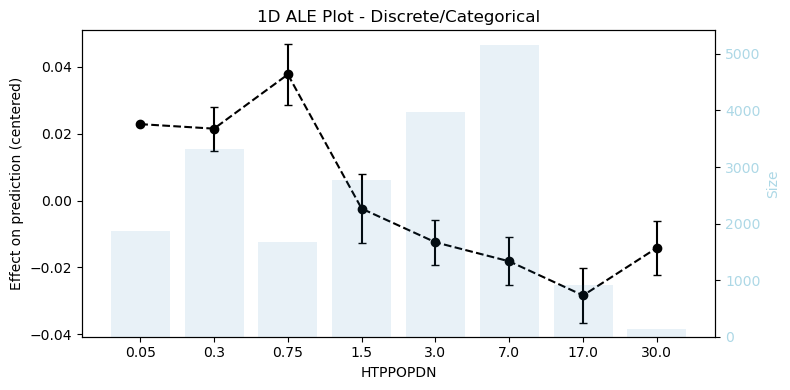

In [70]:
ale(X=df_unencoded, model=tree, feature = ["HTPPOPDN"], grid_size=10, include_CI=True, C=0.95)
fig = plt.gcf()
fig.savefig("Effects of Population Density", bbox_inches = "tight")

PyALE._ALE_generic:INFO: Discrete feature detected.
C:\Users\vubanc\Anaconda3\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
C:\Users\vubanc\Anaconda3\lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


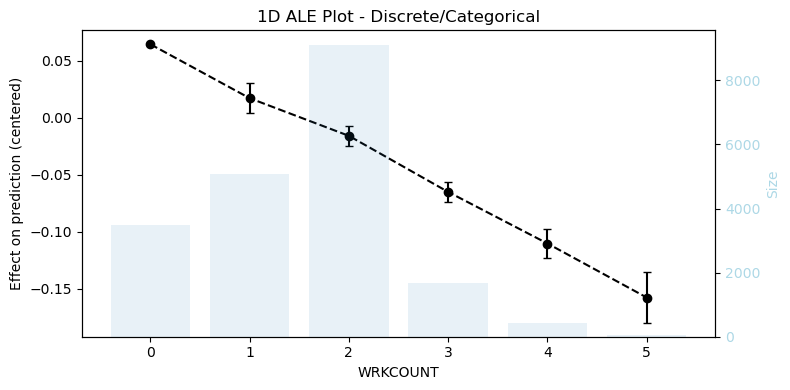

In [71]:
ale(X=df_unencoded, model=tree, feature = ["WRKCOUNT"], grid_size=10, include_CI=True, C=0.95)
fig = plt.gcf()
fig.savefig("Effects of Number of Workers", bbox_inches = "tight")

PyALE._ALE_generic:INFO: Discrete feature detected.
C:\Users\vubanc\Anaconda3\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
C:\Users\vubanc\Anaconda3\lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


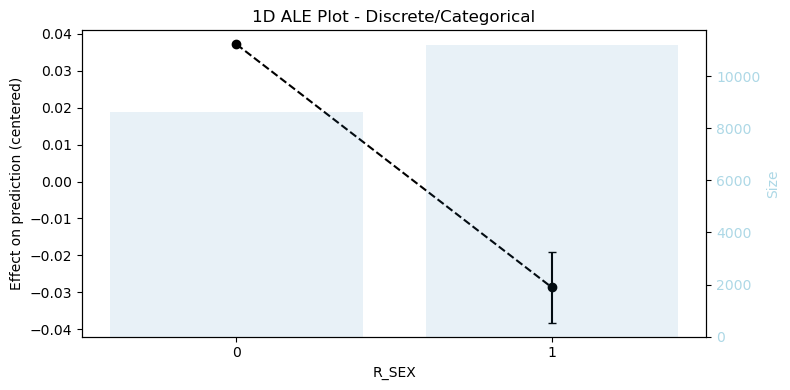

In [72]:
ale(X=df_unencoded, model=tree, feature = ["R_SEX"], grid_size=10, include_CI=True, C=0.95)
fig = plt.gcf()
fig.savefig("Effects of Gender", bbox_inches = "tight")

PyALE._ALE_generic:INFO: Discrete feature detected.
C:\Users\vubanc\Anaconda3\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
C:\Users\vubanc\Anaconda3\lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


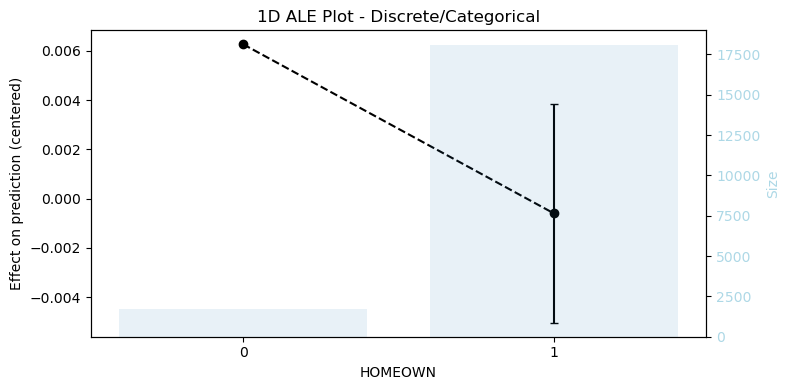

In [73]:
ale(X=df_unencoded, model=tree, feature = ["HOMEOWN"], grid_size=10, include_CI=True, C=0.95)
fig = plt.gcf()
fig.savefig("Effects of Home Ownership", bbox_inches = "tight")

PyALE._ALE_generic:INFO: Discrete feature detected.
C:\Users\vubanc\Anaconda3\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
C:\Users\vubanc\Anaconda3\lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


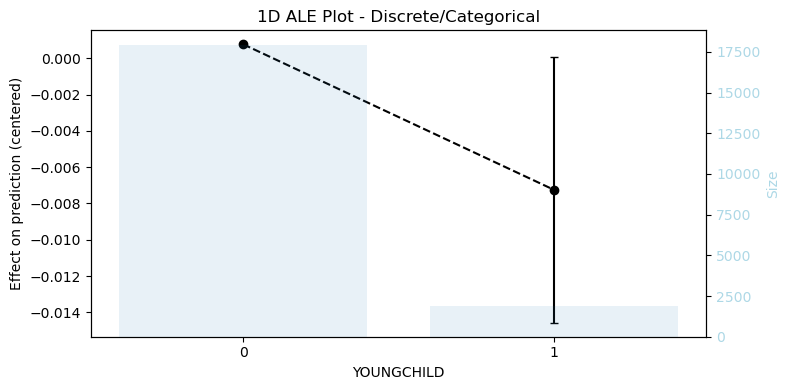

In [48]:
ale(X=df_unencoded, model=tree, feature = ["YOUNGCHILD"], grid_size=10, include_CI=True, C=0.95)
fig = plt.gcf()
fig.savefig("Effects of Number of Children", bbox_inches = "tight")

PyALE._ALE_generic:INFO: Discrete feature detected.
C:\Users\vubanc\Anaconda3\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
C:\Users\vubanc\Anaconda3\lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


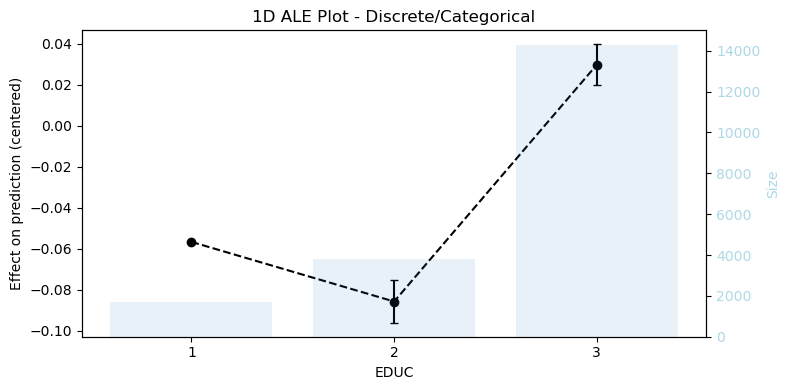

In [49]:
ale(X=df_unencoded, model=tree, feature = ["EDUC"], grid_size=10, include_CI=True, C=0.95)
fig = plt.gcf()
fig.savefig("Effects of Education", bbox_inches = "tight")

PyALE._ALE_generic:INFO: Discrete feature detected.
C:\Users\vubanc\Anaconda3\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
C:\Users\vubanc\Anaconda3\lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


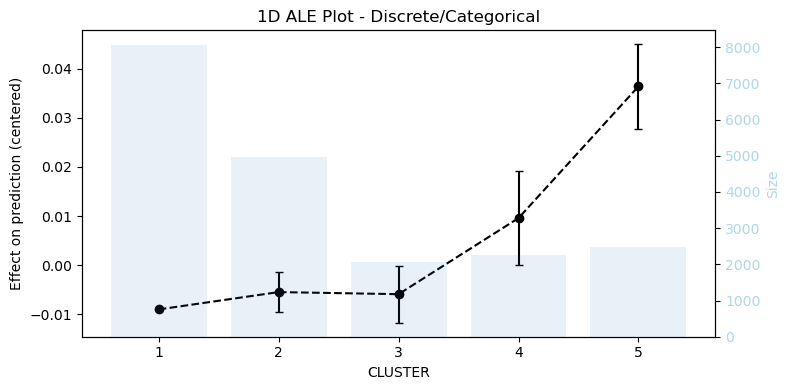

In [50]:
ale(X=df_unencoded, model=tree, feature = ["CLUSTER"], encode_fun = onehot_encode, predictors=list(df_encoded.columns))
fig = plt.gcf()
fig.savefig("Effects of Trip Clusters", bbox_inches = "tight")